In [1]:
!pip install segmentation-models-pytorch
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 9.7 MB/s eta 0:00:00


In [75]:
import cv2
import torch
import kagglehub
import numpy as np

from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision.transforms import v2
import torchvision.transforms.functional as TF
from torchvision.io import decode_image
from torchvision.io.image import ImageReadMode
from torch.utils.data import random_split

from matplotlib import pyplot as plt
import matplotlib.patches as patches

from tqdm import tqdm

import os
from glob import glob
import json

import segmentation_models_pytorch as smp
from skimage import morphology, measure

DEVICE = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
DEVICE

'cuda'

In [ ]:
#### SE FOR RODAR NO KAGGLE
# INPUT_DIR = "/kaggle/input/chest-xray-pneumonia/chest_xray/"
#### SE QUISER RODAR LOCAL OU NO COLAB
INPUT_DIR = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
INPUT_DIR += "/chest_xray/"
# OUTPUT_DIR = "/kaggle/working/weak_masks"
# os.makedirs(OUTPUT_DIR, exist_ok=True)

In [59]:
def generate_weak_mask_cxr(img_path):
    # Carrega a imagem e redimenciona
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    h, w = img.shape
    img = cv2.resize(img, (512, 512))
    # "Estoura" pixels extremos para que não entrem na máscara
    img[img < 50] = 255 
    img[img > 180] = 255
    
    # Equalização + suavização
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    I = clahe.apply(img)
    I = cv2.GaussianBlur(I, (7,7), 0)
    
    for ang in np.arange(0, 151, 30):
        se = np.zeros((15, 15), np.uint8)
        cv2.ellipse(se, (15//2, 15//2), (15//2, 1), ang, 0, 360, 1, -1)
        I_supp = cv2.morphologyEx(I, cv2.MORPH_OPEN, se)
        I = cv2.min(I, I_supp)
        
    # Inverte para que opacidades fiquem claras
    I_inv = cv2.normalize(255 - I, None, 0, 255, cv2.NORM_MINMAX)

    # Filtro bilateral
    I_inv_bilateral = cv2.bilateralFilter(I_inv.astype(np.uint8), d=-1, sigmaColor=0.25*255, sigmaSpace=15)

    # Aplica um treshold simples
    _, bw = cv2.threshold(I_inv_bilateral, 127, 255, cv2.THRESH_BINARY)
    
    # Limpa regiões fora dos pulmões
    # remove um pequeno pedaço do topo e das laterais que não incluem o pulmão (geralmente)
    bw[:40, :], bw[:, -70:], bw[:, :70] = 0,0, 0
    
    # Morfologia para suavizar
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
    bw = cv2.morphologyEx(bw, cv2.MORPH_OPEN, kernel)
    bw = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel)
    
    # Mantém regiões internas
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(bw)
    mask_out = np.zeros_like(bw)
    
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        x,y = stats[i, cv2.CC_STAT_LEFT], stats[i, cv2.CC_STAT_TOP]
        wc,hc = stats[i, cv2.CC_STAT_WIDTH], stats[i, cv2.CC_STAT_HEIGHT]

        # Descarta regiões no topo e muito pequenas
        if area > 500 and y > 39:
            mask_out[labels == i] = 255

    # Remove objetos pequenos (geralmente ombro ou parte da silhueta lateral)
    mask_out = morphology.remove_small_objects(mask_out.astype(bool), min_size=5000)
    
    # Volta ao tamanho original
    mask_out = mask_out.astype(np.uint8)
    mask_out = cv2.resize(mask_out, (w, h))
    
    return torch.from_numpy(mask_out).unsqueeze(0).float()

# Função QC
def qc_score(mask, min_area=0.04, max_area=0.3, min_ecc=0.4, max_ecc=0.98, max_aspect=0.35, num_obj=2):
    props = measure.regionprops(measure.label(mask[0]))
    # Apenas os 2 maiores objetos (idealmente apenas pulmões)
    props = sorted(props, key=lambda x: x.area, reverse=True)[:2]

    H, W = mask[0].shape

    scores = 0

    try:
        biggest_area = props[0].area
    except:
        print(f"Mascara problemática, Nº de objetos nela: {len(props)}")
        return 0

    for p in props:
        lung_scores = list()
        # Área relativa
        area_frac = p.area / (H * W)
        if area_frac < min_area:
            lung_scores.append(area_frac / min_area)
        elif area_frac > max_area:
            lung_scores.append(max_area / area_frac)
        else:
            lung_scores.append(1.0)

        # Eccentricidade
        ecc = p.eccentricity
        if ecc < min_ecc:
            lung_scores.append(ecc / min_ecc)
        elif ecc > max_ecc:
            lung_scores.append(max_ecc / ecc)
        else:
            lung_scores.append(1.0)

        # Solidity
        lung_scores.append(p.solidity)

        # Extent
        lung_scores.append(p.extent)

        # Aspect ratio
        minr, minc, maxr, maxc = p.bbox
        bbox_h = maxr - minr
        bbox_w = maxc - minc
        aspect = max(bbox_h / (bbox_w + 1e-9), bbox_w / (bbox_h + 1e-9))
        if aspect > max_aspect:
            lung_scores.append(max_aspect / aspect)
        else:
            lung_scores.append(1.0)

        # Nº de objetos
        n_obj = len(props)
        if n_obj > num_obj:
            lung_scores.append(1 / n_obj)
        else:
            lung_scores.append(n_obj / num_obj)
       
        # Soma o score do pulmão ao score final ponderado pela diferença de tamanho entre pulmões 
        scores += np.mean(lung_scores) * (p.area / biggest_area)

    return scores / 2 # Média dos pulmões

In [76]:
class SelfSegCXRDataset(Dataset):
    def __init__(self, dataset_path=INPUT_DIR, image_size=None, device=DEVICE):

        self._path_data = dataset_path

        self.data = glob(os.path.join(self._path_data, "**", "**", "*.jpeg"), recursive=True)

        self.device = device

        if image_size:
            self.resize_image = v2.Resize(size=image_size, interpolation=v2.InterpolationMode.BILINEAR, antialias=True)
            self.resize_mask = v2.Resize(size=image_size, interpolation=v2.InterpolationMode.NEAREST)
        else:
            self.resize_image = lambda x: x
            self.resize_mask = lambda x: x

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_path = self.data[index]

        image = decode_image(image_path, mode=ImageReadMode.GRAY).to(self.device)
        mask = generate_weak_mask_cxr(image_path)

        qc = qc_score(mask)

        image = self.resize_image(image)
        mask = self.resize_mask(mask)

        return image, mask, qc

QC_1 = 0.6773622589943364
QC_2 = 0.3081145563422702
QC_3 = 0.7418403665157179
QC_4 = 0.5343226996657487
QC_5 = 0.5718705844305354


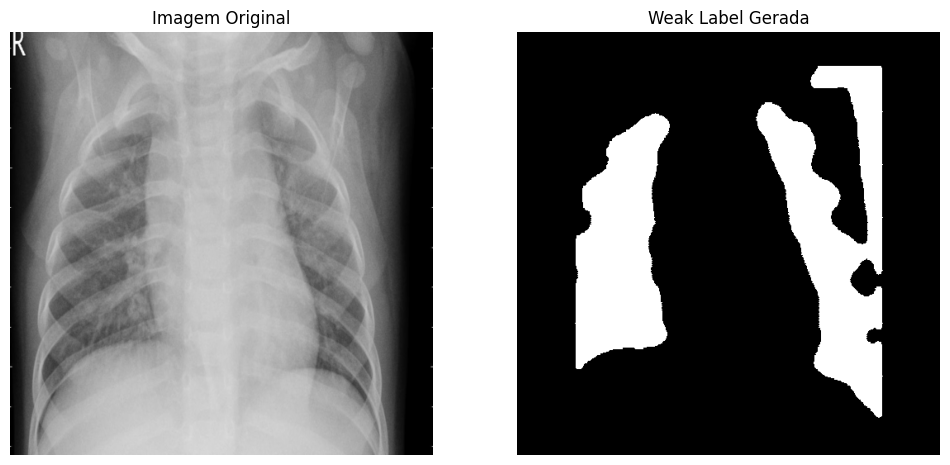

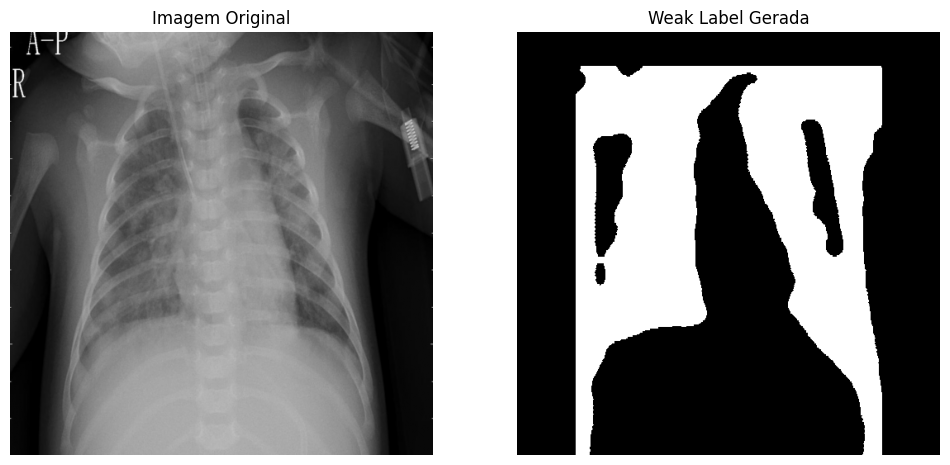

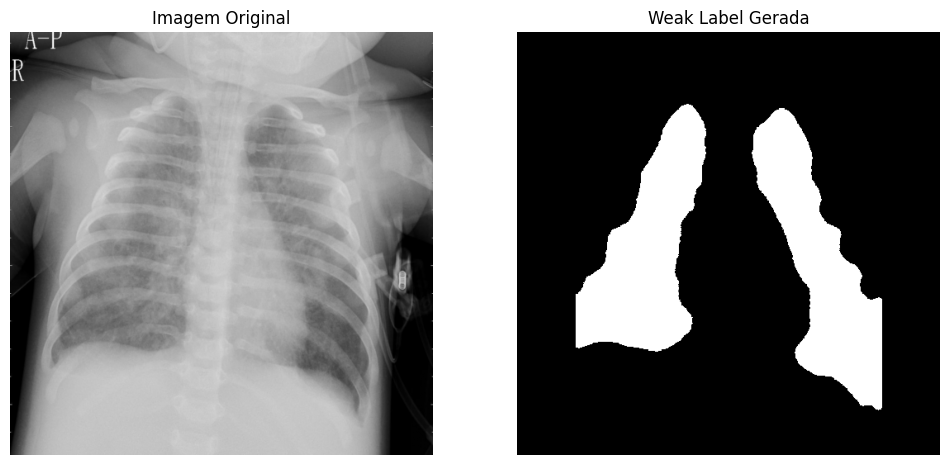

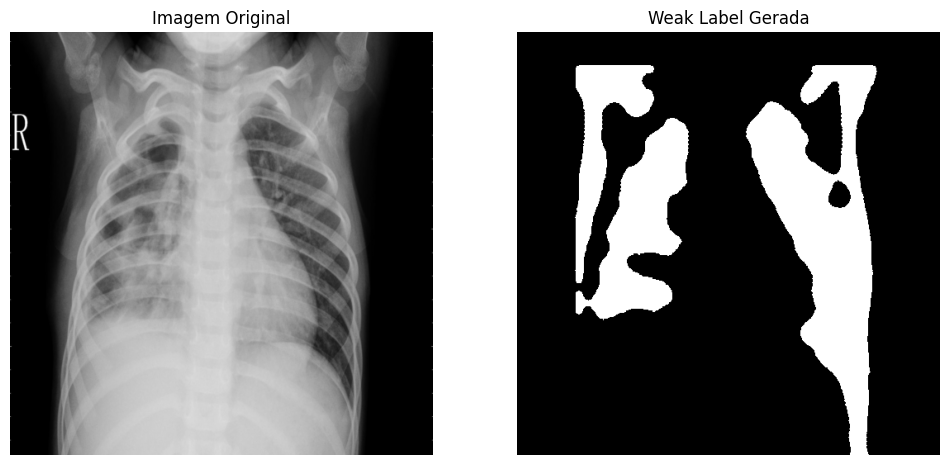

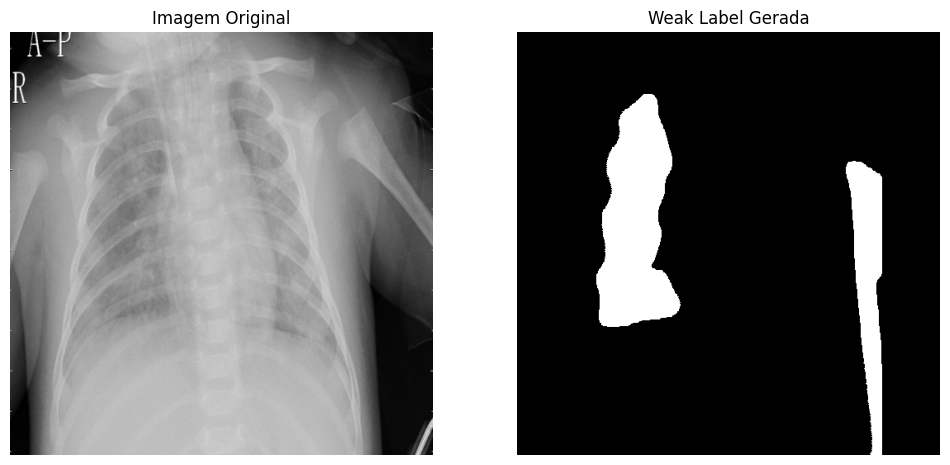

In [77]:
ds = SelfSegCXRDataset(image_size=(512, 512))

for i in range(5):
    img, mask, qc = ds[i]
    
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.title("Imagem Original")
    plt.imshow(img.cpu()[0], cmap="gray")
    plt.axis("off")
    
    plt.subplot(1,2,2)
    plt.title("Weak Label Gerada")
    plt.imshow(mask.cpu()[0], cmap="gray")
    plt.axis("off")

    print(f"QC_{i+1} = {qc}")
    
plt.show()

### Usando UNet com ativação Sigmóide para treinar as Weak Labels

In [78]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1,
    classes=1,
    activation="sigmoid"
)

loss = smp.losses.DiceLoss(mode="binary")

dataset = SelfSegCXRDataset(image_size=(512,512))
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model = model.to(DEVICE)

Mascara problemática, Nº de objetos nela: 0
Mascara problemática, Nº de objetos nela: 0


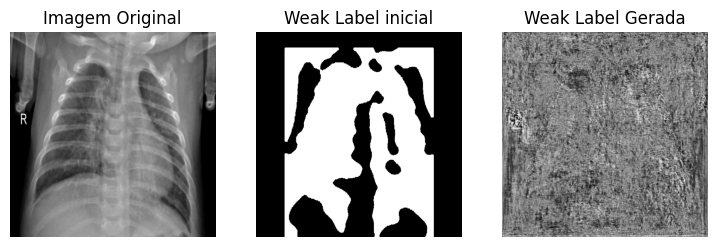

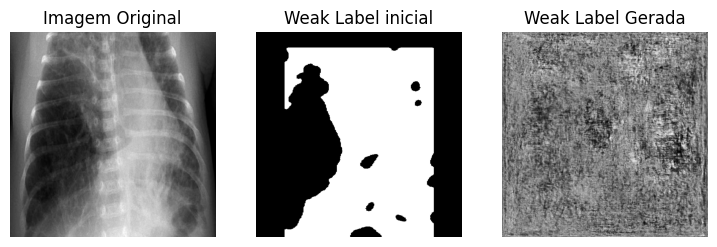

Mascara problemática, Nº de objetos nela: 0


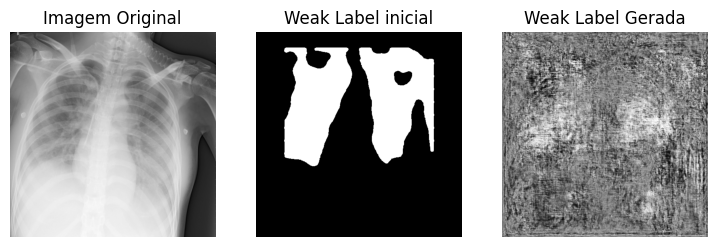

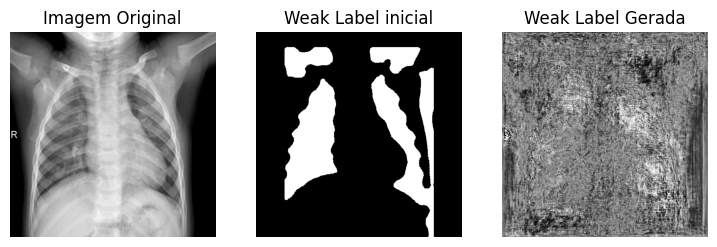

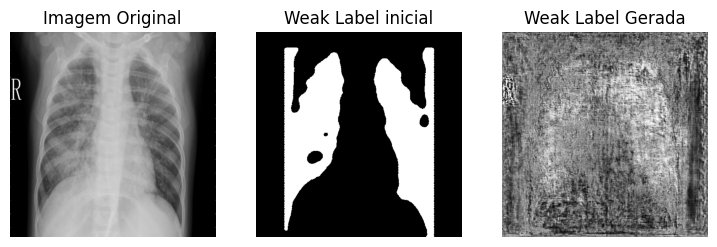

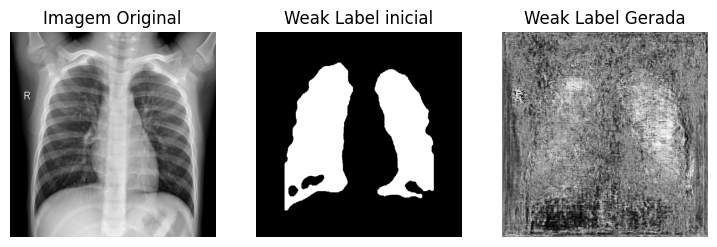

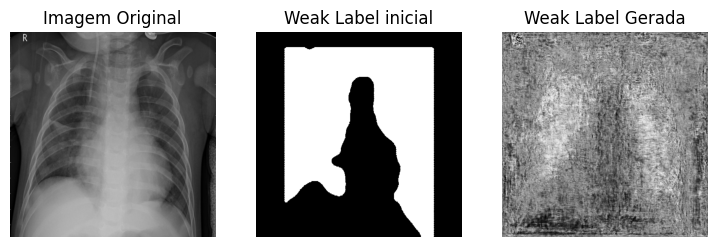

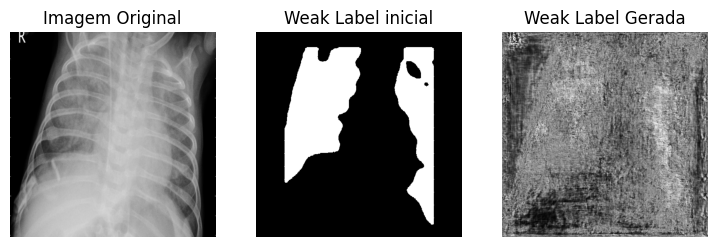

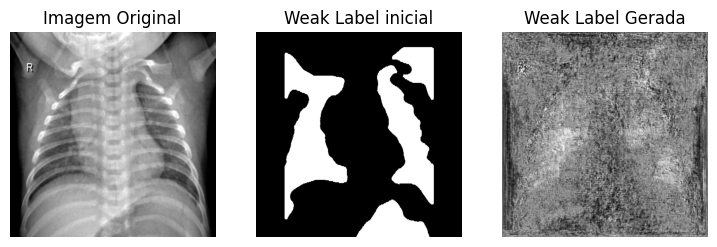

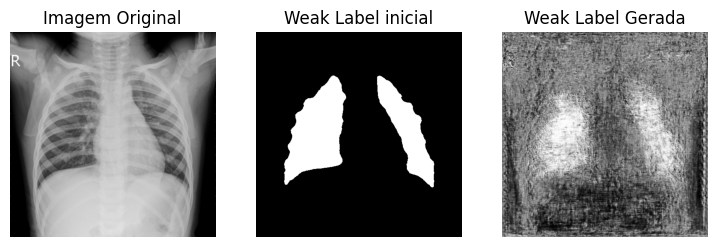

Mascara problemática, Nº de objetos nela: 0


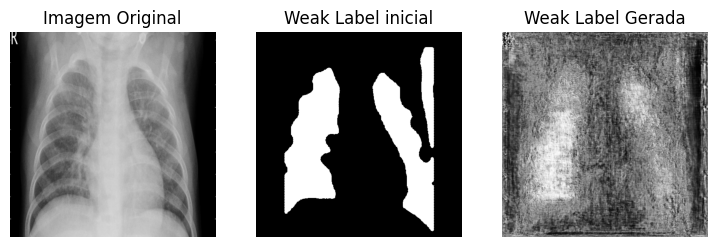

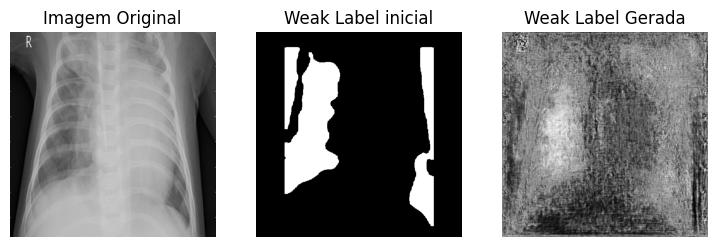

: 

In [ ]:
for epoch in range(20):
    model.train()
    total = 0

    for i, (imgs, masks, qc) in enumerate(train_loader):
        imgs = imgs.to(DEVICE).float()
        masks = masks.to(DEVICE)

        preds = model(imgs)
        loss_value = loss(preds, masks)

        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

        total += loss_value.item()
        
        for k in range(2):
            plt.figure(figsize=(9,3))

            plt.subplot(1,3,1)
            plt.title("Imagem Original")
            plt.imshow(imgs[k].cpu()[0], cmap="gray")
            plt.axis("off")

            plt.subplot(1,3,2)
            plt.title("Weak Label inicial")
            plt.imshow(masks[k].cpu()[0], cmap="gray")
            plt.axis("off")
            
            plt.subplot(1,3,3)
            plt.title("Weak Label Gerada")
            plt.imshow(preds[k].detach().cpu()[0], cmap="gray")
            plt.axis("off")

            plt.show()